# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

Set cells width

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

### V2. Larger setting

In [3]:
from experiments_utils import generate_parameters

dim = 10
max_jumps=6e3 * dim

param_dict = generate_parameters(dim=dim, base_range=[0.05, 0.05], adj_range=[0.1, 0.2], seed=11)

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
Alpha:
[[ 0.11  0.12  0.00  0.12  0.18  0.19  0.00  0.11  0.00  0.00]
 [ 0.00  0.12  0.12  0.00  0.00  0.12  0.00  0.17  0.15  0.11]
 [ 0.14  0.00  0.14  0.00  0.13  0.00  0.19  0.00  0.00  0.14]
 [ 0.19  0.13  0.00  0.00  0.14  0.00  0.00  0.00  0.00  0.13]
 [ 0.14  0.13  0.00  0.00  0.10  0.17  0.15  0.00  0.00  0.13]
 [ 0.00  0.12  0.13  0.00  0.00  0.11  0.13  0.00  0.00  0.11]
 [ 0.00  0.00  0.15  0.00  0.13  0.19  0.00  0.00  0.00  0.17]
 [ 0.00  0.18  0.13  0.12  0.11  0.00  0.00  0.19  0.00  0.11]
 [ 0.00  0.00  0.11  0.00  0.10  0.16  0.00  0.00  0.00  0.00]
 [ 0.00  0.11  0.11  0.17  0.18  0.15  0.14  0.00  0.11  0.00]]
Beta:
[[ 0.73  0.11  0.89  0.86  0.17  0.63  0.02  0.12  0.32  0.16]
 [ 0.76  0.82  0.34  0.32  0.11  0.08  0.71  0.60  0.06  0.48]
 [ 0.40  0.85  0.72  0.60  0.55  0.95  0.99  0.34  0.24  0.80]
 [ 0.06  0.36  0.07  0.32  0.07  0.29  0.79  0.91  0.79  0.56]
 [ 0.62  0.36  0.17  0.44  0.73 

### Simulate a realization

In [4]:
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=1234)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 60,000 events with end time: 26181.736328125
    - Events:
      - dim  0 ( 4960 events): [ 1.44e+01  2.66e+01  3.09e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  1 ( 7333 events): [    31.41     32.47     34.98 ...  26175.02  26176.96  26181.18]
      - dim  2 ( 7024 events): [ 4.60e+00  2.31e+01  2.49e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  3 ( 3779 events): [    51.82     64.82     68.81 ...  26160.94  26165.87  26166.26]
      - dim  4 ( 8078 events): [ 1.14e+01  1.65e+01  2.16e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  5 ( 9037 events): [ 1.37e+01  1.64e+01  1.90e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  6 ( 5769 events): [ 4.25e-01  1.31e+01  1.95e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  7 ( 4060 events): [ 1.58e+00  5.19e+00  1.59e+01 ...  2.62e+04  2.62e+04  2.62e+04]
      - dim  8 ( 3165 events): [ 1.06e+01  2.43e+01  6.50e+01 ...  2.61e+04  2.62e+04  2.62e+04]
      - dim  9 ( 6795 e

---

## Test Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Define the parameters of the prior.

In [9]:
# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 1001.0 * np.ones((dim, dim))
br_pr = 1000.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr / ar_pr)
print('variance')
print(as_pr / ar_pr ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr / (bs_pr - 1))
print('variance')
print(br_pr**2 / ((bs_pr - 1)**2 * (bs_pr - 2)))

ALPHA:
------
mean
[[ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]]
variance
[[ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10  0.10]
 [ 0.10  0.10  0.10  0.10 

Fit the model.

In [10]:
class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.extra = {'bs_po':[], 'br_po':[], 'as_po':[], 'ar_po':[], 'zp_po': []}
    
    def __call__(self, obj, **kwargs):
        super().__call__(obj, **kwargs)
        self.extra['bs_po'].append(obj._bs_po)
        self.extra['br_po'].append(obj._br_po)
        self.extra['as_po'].append(obj._as_po)
        self.extra['ar_po'].append(obj._ar_po)
        self.extra['zp_po'].append(obj._zp_po)
        
# Set callback to monitor progress
coeffs_start = alpha.numpy().flatten().copy()
callback = MyCallback(x0=coeffs_start,print_every=10, 
                      coeffs_true=alpha.numpy().flatten(), 
                      acc_thresh=0.05, dim=dim, default_end='\n')

# Set model & observations
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

# Fit model
model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

---- Alpha
    as: min:+2.88e+02, max:+8.22e+02
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.10e-02, max:+1.47e-01
---- Beta
    x0: min:+1.02e+00, max:+1.14e+00
    xn: min:+1.02e+00, max:+1.14e+00
    bs: min:+1.01e+03, max:+1.19e+03
    br: min:+1.06e+03, max:+1.30e+03
b_mean: min:+1.02e+00, max:+1.14e+00
---- Alpha
    as: min:+2.74e+02, max:+8.63e+02
    ar: min:+5.33e+03, max:+2.62e+04
a_mean: min:+1.14e-02, max:+1.56e-01
---- Beta
    x0: min:+9.86e-01, max:+1.04e+00
    xn: min:+9.87e-01, max:+1.04e+00
    bs: min:+1.06e+03, max:+1.26e+03
    br: min:+1.06e+03, max:+1.29e+03
b_mean: min:+9.87e-01, max:+1.04e+00
---- Alpha
    as: min:+2.62e+02, max:+8.89e+02
    ar: min:+5.56e+03, max:+2.62e+04
a_mean: min:+1.15e-02, max:+1.52e-01
---- Beta
    x0: min:+9.82e-01, max:+1.02e+00
    xn: min:+9.83e-01, max:+1.02e+00
    bs: min:+1.06e+03, max:+1.28e+03
    br: min:+1.06e+03, max:+1.28e+03
b_mean: min:+9.84e-01, max:+1.02e+00
---- Alpha
    as: min:+2.50e+02, max:+9.21e+02
 

---- Alpha
    as: min:+1.02e+02, max:+1.38e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.33e-02, max:+1.78e-01
---- Beta
    x0: min:+9.89e-01, max:+1.01e+00
    xn: min:+9.90e-01, max:+1.01e+00
    bs: min:+1.02e+03, max:+1.43e+03
    br: min:+1.02e+03, max:+1.41e+03
b_mean: min:+9.90e-01, max:+1.01e+00
---- Alpha
    as: min:+9.90e+01, max:+1.40e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.31e-02, max:+1.80e-01
---- Beta
    x0: min:+9.89e-01, max:+1.01e+00
    xn: min:+9.90e-01, max:+1.01e+00
    bs: min:+1.02e+03, max:+1.43e+03
    br: min:+1.02e+03, max:+1.42e+03
b_mean: min:+9.90e-01, max:+1.01e+00
---- Alpha
    as: min:+9.62e+01, max:+1.41e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.27e-02, max:+1.80e-01
---- Beta
    x0: min:+9.89e-01, max:+1.01e+00
    xn: min:+9.90e-01, max:+1.01e+00
    bs: min:+1.02e+03, max:+1.44e+03
    br: min:+1.02e+03, max:+1.42e+03
b_mean: min:+9.91e-01, max:+1.01e+00
---- Alpha
    as: min:+9.35e+01, max:+1.42e+03
 

iter:    50 | dx: +4.9070e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 2.16e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.19e-01     
---- Alpha
    as: min:+5.59e+01, max:+1.56e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+6.80e-03, max:+1.88e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.01e+03, max:+1.48e+03
    br: min:+1.01e+03, max:+1.47e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+5.47e+01, max:+1.56e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+6.64e-03, max:+1.88e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.01e+03, max:+1.48e+03
    br: min:+1.01e+03, max:+1.47e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+5.36e+01, max:+1.57e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+6.48e-03, max:+1.88e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.01e+

---- Alpha
    as: min:+3.06e+01, max:+1.61e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+3.61e-03, max:+1.88e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.01e+03, max:+1.49e+03
    br: min:+1.01e+03, max:+1.48e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+2.97e+01, max:+1.61e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+3.51e-03, max:+1.88e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.01e+03, max:+1.49e+03
    br: min:+1.01e+03, max:+1.48e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+2.89e+01, max:+1.61e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+3.42e-03, max:+1.88e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.01e+03, max:+1.49e+03
    br: min:+1.01e+03, max:+1.48e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+2.81e+01, max:+1.61e+03
 

iter:   100 | dx: +1.6852e-04 | acc: 0.99 | f1-score: 0.99 | relerr: 1.85e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.26e-01     
---- Alpha
    as: min:+1.33e+01, max:+1.62e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.57e-03, max:+1.87e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+1.27e+01, max:+1.63e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.50e-03, max:+1.87e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+1.21e+01, max:+1.64e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.43e-03, max:+1.86e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+

---- Alpha
    as: min:+1.31e+00, max:+1.82e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.55e-04, max:+1.85e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+9.44e-01, max:+1.83e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.12e-04, max:+1.85e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+6.04e-01, max:+1.84e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+7.13e-05, max:+1.85e-01
---- Beta
    x0: min:+9.94e-01, max:+1.01e+00
    xn: min:+9.95e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+3.14e-01, max:+1.84e+03
 

iter:   150 | dx: +1.0425e-04 | acc: 0.97 | f1-score: 0.97 | relerr: 1.74e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.28e-01     
---- Alpha
    as: min:+1.00e-01, max:+1.98e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.18e-05, max:+1.84e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+1.99e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.18e-05, max:+1.84e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.95e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+1.99e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.18e-05, max:+1.84e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+

---- Alpha
    as: min:+1.00e-01, max:+2.11e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.08e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.12e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.08e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.12e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.08e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.50e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.12e+03
 

iter:   200 | dx: +7.5799e-05 | acc: 0.97 | f1-score: 0.97 | relerr: 1.68e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.28e-01     
---- Alpha
    as: min:+1.00e-01, max:+2.21e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.21e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.49e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.22e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.83e-01
---- Beta
    x0: min:+9.93e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+

---- Alpha
    as: min:+1.00e-01, max:+2.29e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.29e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.29e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+1.03e-05, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.30e+03
 

---- Alpha
    as: min:+1.00e-01, max:+2.35e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.35e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.35e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.36e+03
 

---- Alpha
    as: min:+1.00e-01, max:+2.40e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.40e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.40e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.82e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.94e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.40e+03
 

iter:   300 | dx: +6.3873e-05 | acc: 0.97 | f1-score: 0.97 | relerr: 1.62e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.26e-01     
---- Alpha
    as: min:+1.00e-01, max:+2.43e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.81e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.93e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.43e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.81e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.93e-01, max:+1.01e+00
    bs: min:+1.00e+03, max:+1.49e+03
    br: min:+1.00e+03, max:+1.48e+03
b_mean: min:+9.94e-01, max:+1.01e+00
---- Alpha
    as: min:+1.00e-01, max:+2.44e+03
    ar: min:+5.59e+03, max:+2.62e+04
a_mean: min:+9.64e-06, max:+1.81e-01
---- Beta
    x0: min:+9.92e-01, max:+1.01e+00
    xn: min:+9.93e-01, max:+1.01e+00
    bs: min:+1.00e+

KeyboardInterrupt: 

Extract the runtime

In [10]:
hist = callback.to_dict()
np.mean(hist['time'][1:]) * hist['iter'][-1]

150.9284759651531

In [11]:
hist_arr = np.array(hist['relerr'])
n = 100

arr = np.abs(np.diff(hist_arr, axis=0))
indices = np.arange(len(arr))

vals = np.zeros_like(arr)
for i in range(len(arr)):
    arr_i = arr[:i]
    indices_i = indices[:i]
    if i >= max(2, n):
        val = np.mean(np.abs(np.diff(arr_i[-n:])))
        vals[i] = val
    else:
        vals[i] = np.nan

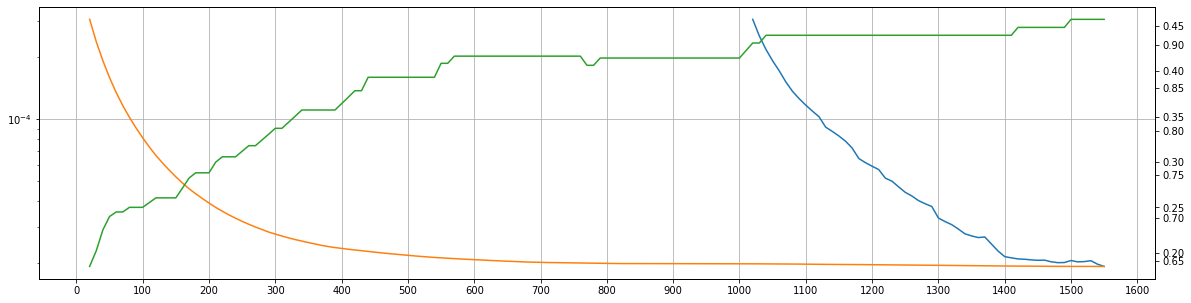

In [12]:
x = hist['iter'][1:]
y_fsc = hist['f1score'][1:]
y_rel = hist['relerr'][1:]

fig, ax = plt.subplots(figsize=(20,5))
plt.grid()

plt.plot(x, vals)
ax.set_yscale('log')

ax.set_xticks(np.arange(0, 2500, 100));

ax2 = ax.twinx() 
ax2.plot(x, y_rel, c='C1')
#ax2.grid(ls=':', c='g')

ax3 = ax.twinx()
ax3.plot(x, y_fsc, c='C2')




In [11]:
iter_a_mean = np.array(callback.extra['as_po']) / np.array(callback.extra['ar_po'])


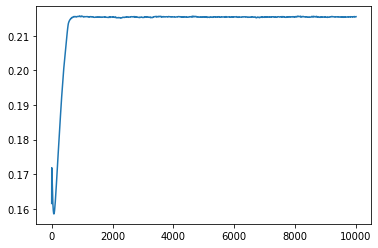

In [17]:
plt.plot(iter_a_mean[:,1,1])

---

Show results

In [49]:
alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adj_true = alpha.numpy()
adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adjacency_hat)

fp = tsvar.utils.metrics.false_positive(adjacency_hat.flatten(), adj_true.flatten()) / np.prod(adj_true.shape)
fn = tsvar.utils.metrics.false_negative(adjacency_hat.flatten(), adj_true.flatten()) / np.prod(adj_true.shape)
tp = tsvar.utils.metrics.true_positive(adjacency_hat.flatten(), adj_true.flatten()) / np.prod(adj_true.shape)
tn = tsvar.utils.metrics.true_negative(adjacency_hat.flatten(), adj_true.flatten()) / np.prod(adj_true.shape)
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten())
print('True Positive Rate:', tp)
print('True Negative Rate:', tn)
print('False Positive Rate:', fp)
print('False Negative Rate:', fn)
print('F1-Score:', fscore)
print()

beta_hat = np.round(model._br_po / (model._bs_po - 1), 2)
print('Beta:')
print('-----')
print('Ground truth:')
print(beta.numpy() * np.ones((dim, dim)) + 1)
print('Estimated:')
print(beta_hat)
print(pd.Series(beta_hat.flatten()).describe())

Baseline:
---------
Ground truth:
[ 0.02  0.02  0.04  0.02  0.01  0.03  0.03  0.04  0.01  0.01]
Estimated:
[ 0.01  0.02  0.02  0.04  0.00  0.02  0.03  0.04  0.01  0.00]

Adjacency:
---------
Ground truth:
[[ 0.85  0.64  0.00  0.79  0.00  0.00  0.00  0.65  0.78  0.00]
 [ 0.88  0.87  0.00  0.00  0.00  0.79  0.00  0.66  0.84  0.81]
 [ 0.00  0.00  0.00  0.65  0.53  0.83  0.62  0.00  0.00  0.79]
 [ 0.00  0.00  0.60  0.00  0.00  0.56  0.00  0.00  0.85  0.58]
 [ 0.00  0.50  0.00  0.00  0.82  0.00  0.00  0.00  0.00  0.00]
 [ 0.58  0.00  0.51  0.83  0.00  0.00  0.87  0.53  0.00  0.65]
 [ 0.00  0.00  0.73  0.00  0.86  0.61  0.00  0.00  0.00  0.60]
 [ 0.00  0.70  0.00  0.00  0.55  0.71  0.53  0.00  0.61  0.72]
 [ 0.81  0.00  0.67  0.00  0.00  0.00  0.57  0.00  0.00  0.89]
 [ 0.61  0.00  0.66  0.85  0.51  0.00  0.00  0.00  0.89  0.00]]
Estimated:
[[ 0.53  0.29  0.09  0.61  0.27  0.00  0.10  0.40  0.07  0.00]
 [ 0.42  0.71  0.19  0.00  0.00  0.62  0.00  0.49  1.17  0.34]
 [ 0.00  0.00  0.00  0.47  

In [99]:
bs = np.array([e[3,0] for e in callback.extra['bs_po']])
br = np.array([e[3,0] for e in callback.extra['br_po']])

In [100]:
adjacency_hat[3,:] / beta_hat[3,:]

array([ 0.53,  0.43,  0.85,  0.35,  0.04,  0.29])

In [101]:
alpha.numpy()[3,:] / beta.numpy()[3, :]

array([  1.37,   0.78,  17.98,   0.63,   0.00,   0.93], dtype=float32)

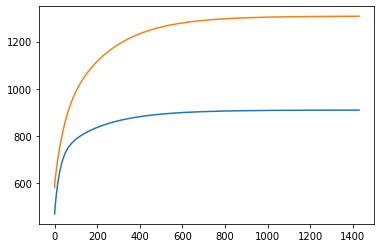

In [102]:
plt.plot(bs)
plt.plot(br)

In [103]:
zp = np.array([e[3] for e in callback.extra['zp_po']])

In [110]:
zp[-1, :, 0] # (num iter, event k, dim j)

array([ 1.00,  0.00,  0.00, ...,  0.00,  0.00,  0.00])

In [60]:
from tsvar.models._wold_var import expect_inv_beta_p_delta
valid_mask_ikj = model.valid_mask_ikj
dt_ik = model.dt_ik
delta_ikj = model.delta_ikj
bs_po = model._bs_po
br_po = model._br_po
i = 0

D_i_kj = (valid_mask_ikj[i][:, 1:] * np.expand_dims(dt_ik[i], 1) *
          expect_inv_beta_p_delta(bs_po[:, i], br_po[:, i],
                                  delta_ikj[i][:, 1:] + 1e-20))

In [65]:
D_i_kj.shape

(5846, 6)

In [61]:
D_i_kj.sum(axis=0)

array([ 2401.31,  1919.47,  2408.14,   127.91,  2863.99,  2493.79])

In [62]:
(valid_mask_ikj[i][:, 0] * dt_ik[i]).sum(axis=0)

4339.02197265625

In [84]:
model._zp_po[3][:, :] # (events k, dim j)

array([[ 0.00,  0.23,  0.07, ...,  0.18,  0.15,  0.27],
       [ 0.00,  0.24,  0.01, ...,  0.30,  0.09,  0.29],
       [ 0.00,  0.34,  0.07, ...,  0.09,  0.11,  0.32],
       ...,
       [ 0.00,  0.22,  0.07, ...,  0.20,  0.07,  0.30],
       [ 0.00,  0.28,  0.04, ...,  0.06,  0.11,  0.38],
       [ 0.00,  0.30,  0.03, ...,  0.19,  0.20,  0.21]])

In [80]:
model._as_po

array([[    7.36,     6.92,     7.05,     6.85,     7.40,     7.43],
       [  270.97,   575.72,   504.27,  1380.65,   988.27,   363.61],
       [  262.49,    25.06,    67.08,   272.76,   629.46,    70.33],
       [  196.51,   422.67,   183.04,   466.02,    36.35,   207.07],
       [ 3963.83,  2474.52,  5199.08,   916.17,  2769.27,  3587.03],
       [  791.02,    21.46,    13.42,   728.17,    13.85,    65.75],
       [  360.82,    11.64,   280.05,  1520.38,    85.39,   274.79]])

In [81]:
model._ar_po

array([[ 4340.02,  4336.44,  4339.76,  4339.88,  4339.86,  4338.34],
       [ 2399.00,  2489.73,  2498.02,  2497.41,  2745.32,  2154.99],
       [ 1916.36,  2119.09,  2131.57,  1679.20,  2948.52,  2145.60],
       [ 2406.28,  3602.85,  3163.59,  2031.00,  2494.01,  3056.55],
       [  131.11,   301.64,   165.89,  2119.93,    14.94,    19.57],
       [ 2859.61,  2257.19,  2284.85,  2075.69,  2297.89,  2404.57],
       [ 2492.21,  2290.02,  3122.57,  2374.90,  2504.06,  3095.00]])

---

Debug optimization of $x_0$ and $x_n$

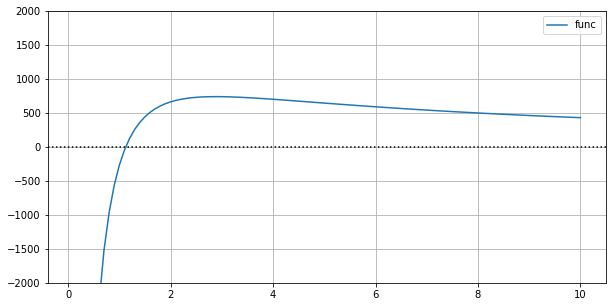

In [36]:
kwargs = {'bs_pr': model._bs_pr, 'br_pr': model._br_pr, 
          'as_po': model._as_po, 'ar_po': model._ar_po, 
          'zp_po': model._zp_po, 'dts': model.dt_ik, 
          'delta': model.delta_ikj, 'valid_mask': model.valid_mask_ikj}

x = np.linspace(0.1, 10.0, 100)
j=0
i=1
n=0
y = [tsvar.models._wold_var.func(e, j=j, i=i, n=n, **kwargs) for e in x]
dy = [tsvar.models._wold_var.fprime(e, j=j, i=i, n=n, **kwargs) for e in x]
ddy = [tsvar.models._wold_var.fprime2(e, j=j, i=i, n=n, **kwargs) for e in x]

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(x, y, c='C0', label='func')
#plt.plot(x, dy, c='C1', label="fprime")
#plt.plot(x, ddy, c='C2', label='fprime2')
plt.legend()
plt.ylim(-2000.0, 2000.0)
plt.axhline(0.0, c='k', ls=':')

---

## Plot exact and approximated densities of $\beta$

In [408]:
# Set model & add observations
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)

beta_range = np.linspace(0.01, 5.0, 110)

i = 0
j = 0

true_post = tsvar.models._wold_var.exact_beta_density(
    beta_range=beta_range,
    bs_pr=10.0,  # beta shape
    br_pr=10.0,  # beta rate
    as_po=0.2,  # alpha shape
    ar_po=1.0,  # alpha rate
    zp_po=0.33 * np.ones(model.n_jumps[i]),  # Uniform Z p=0.33 for all
    dts=model.dt_ik[i],
    delta=model.delta_ikj[i][:, j+1],
    valid_mask=model.valid_mask_ikj[i][:,j+1])

true_post

array([ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01,  0.02,  0.03,  0.04,  0.05,  0.05,  0.06,  0.06,  0.06,  0.06,  0.06,  0.05,  0.05,  0.04,  0.04,  0.04,  0.03,  0.03,  0.03,  0.02,  0.02,  0.02,  0.02,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
        0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00])

In [409]:
approx_post = tsvar.models._wold_var.approx_beta_density(
    beta_range=beta_range, 
    j=j, i=i, 
    x0=1.0, xn=1.0, n=2, 
    
    as_po=0.2 * np.ones((3, 2)), 
    ar_po=1.0 * np.ones((3, 2)), 
    
    zp_po=[0.33 * np.ones((model.n_jumps[i], 3))], 
    
    bs_pr=10.0 * np.ones((2, 2)), 
    br_pr=10.0 * np.ones((2, 2)), 
    
    dt_ik=model.dt_ik, 
    delta_ikj=model.delta_ikj, 
    valid_mask_ikj=model.valid_mask_ikj)

10.000000099000001 10.000000100000001


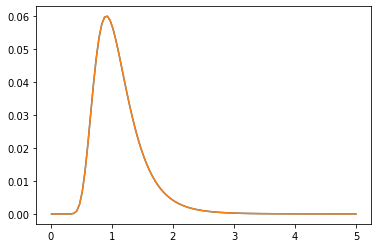

In [410]:
plt.plot(beta_range, true_post)
plt.plot(beta_range, approx_post)